# 03 - Implementation of Deep Convolutional GAN (DCGAN)
 
 
    Deep Convolutional GAN from "https://arxiv.org/pdf/1511.06434.pdf%5D" (2016, A. Radford et. al.)

    Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

    Author-email:  mskang@handong.edu

    python and pytorch version: python=3.7, pytorch=1.6

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
from tqdm import tqdm
import random

from torchvision.utils import save_image, make_grid
from torchvision.datasets import CelebA
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

# Step 00. Hyperparameter Setting

In [2]:
# Dataset Info.
dataset_path = '~/datasets'
kwargs = {'num_workers': 1, 'pin_memory': True} 
noise_dim=100
sample_dim = 3
image_size = 64

# CUDA and GPU Info.
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Training info.
seed = 999
batch_size = 128
test_batch_size = 64
gen_lr = 0.0002
disc_lr = 0.0002
epochs = 5
generator_train_step = 1
discriminator_train_step = 1

# log step
log_step = 50

# Step 01. Download CelebA Dataset

In [3]:
celeb_transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

celeb_a = CelebA(dataset_path, transform=celeb_transform, split='all', download=True)
data_loader = DataLoader(dataset=celeb_a, batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


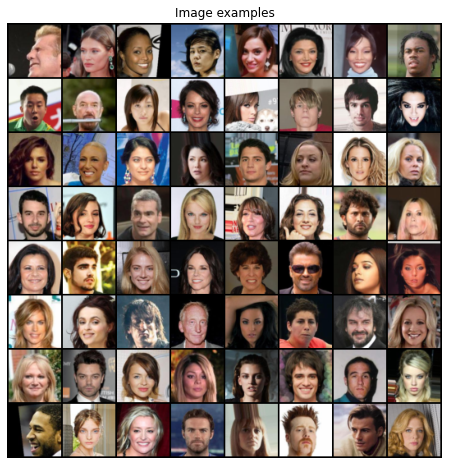

In [4]:
# see training examples

real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Image examples")
plt.imshow(np.transpose(make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Step 02. Define Model

In [5]:
random.seed(seed)
torch.manual_seed(seed)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Simple Convs Generator

class Generator(nn.Module):
    
    
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()        
        
        self.convs = nn.Sequential(
        
            # project
            nn.ConvTranspose2d(input_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # conv1
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # conv2
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # conv3
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # conv4
            nn.ConvTranspose2d(64, output_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        y_ = x
        return self.convs(y_) 

In [7]:
G = Generator(input_dim=noise_dim, output_dim=sample_dim).to(DEVICE)
G.apply(weights_init)

Generator(
  (convs): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        
        self.convs = nn.Sequential(
        
            # (B, 64, 64, 3) ==> (B, 32, 32, 64)
            nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 32, 32, 64) ==> (B, 16, 16, 128)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            ## (B, 16, 16, 128) ==> (B, 8, 8, 256)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 8, 8, 256) ==> (B, 4, 4, 512)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 4, 4, 512) ==> (B, 1, 1, 1)
            nn.Conv2d(512, output_dim, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        y_ = x
        return self.convs(y_).view(-1)

In [9]:
D = Discriminator(input_dim=sample_dim, output_dim=1).to(DEVICE)
D.apply(weights_init)

Discriminator(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Step 03. Define Loss function and optimizer

In [10]:
criterion = nn.BCELoss()

D_optim = torch.optim.Adam(D.parameters(), lr=disc_lr, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=gen_lr, betas=(0.5, 0.999))

# Step 04. Train Deep Convolutional GAN

In [11]:
def train_D(D, G, x, noise, D_labels, D_fakes):
    
    x_fake = G(noise)
    y_hat = D(x)
    y_hat_fake = D(x_fake.detach())
    
    return criterion(y_hat, D_labels) + criterion(y_hat_fake, D_fakes), (y_hat.mean(), y_hat_fake.mean())

def train_G(D, G, D_labels, noise):
    y_hat = D(G(noise))
    return criterion(y_hat, D_labels), y_hat.mean()

In [12]:
print("Start training Deep Convolutional GAN...")

for epoch in range(epochs):
    
    for step, (x, _) in enumerate(data_loader):
        d_batch_size = x.shape[0]
        
        D_labels = torch.ones((d_batch_size)).to(DEVICE) #  Discriminator Label to real
        D_fakes = torch.zeros((d_batch_size)).to(DEVICE) # Discriminator Label to fake
        x = x.view(d_batch_size, sample_dim, image_size, image_size).to(DEVICE)
        noise = torch.randn((d_batch_size, noise_dim, 1, 1)).to(DEVICE)
        
        # Train Discriminator
        G.eval()
        D.train()
        
        for _ in range(discriminator_train_step):
            D_optim.zero_grad()
            D_loss, D_accs = train_D(D, G, x, noise, D_labels, D_fakes)
            D_loss.backward()
            D_optim.step()
        
        
        # Train Generator
        G.train()
        
        for _ in range(generator_train_step):
            G_optim.zero_grad()
            G_loss, G_acc = train_G(D, G, D_labels, noise)
            G_loss.backward()
            G_optim.step()
        
        if step % log_step == 0:
            print("\t[{}/{}]".format(epoch+1, epochs), \
                  "[{}/{}]".format(step, len(data_loader)), \
                  "   Gen.Loss",  "%.4f"%G_loss.item(), \
                  "   Disc.Loss: ", "%.4f"%D_loss.item(), \
                  "   D(x):", "%.2f"%D_accs[0].item(),\
                  "   D((G(z))): ", "Gen.", "%.2f"%G_acc.item(), " / Disc.", "%.2f"%D_accs[1].item()\
                 )
            
        step += 1
        
print("Finish!!")

Start training Deep Convolutional GAN...
	[1/5] [0/1583]    Gen.Loss 5.1792    Disc.Loss:  1.7974    D(x): 0.60    D((G(z))):  Gen. 0.01  / Disc. 0.62
	[1/5] [50/1583]    Gen.Loss 26.6265    Disc.Loss:  0.3393    D(x): 0.85    D((G(z))):  Gen. 0.00  / Disc. 0.00
	[1/5] [100/1583]    Gen.Loss 32.0372    Disc.Loss:  0.0755    D(x): 0.97    D((G(z))):  Gen. 0.00  / Disc. 0.00
	[1/5] [150/1583]    Gen.Loss 3.9295    Disc.Loss:  0.2634    D(x): 0.86    D((G(z))):  Gen. 0.14  / Disc. 0.01
	[1/5] [200/1583]    Gen.Loss 3.6538    Disc.Loss:  0.5290    D(x): 0.92    D((G(z))):  Gen. 0.07  / Disc. 0.28
	[1/5] [250/1583]    Gen.Loss 3.5676    Disc.Loss:  0.5721    D(x): 0.86    D((G(z))):  Gen. 0.05  / Disc. 0.29
	[1/5] [300/1583]    Gen.Loss 2.5005    Disc.Loss:  1.3982    D(x): 0.48    D((G(z))):  Gen. 0.16  / Disc. 0.01
	[1/5] [350/1583]    Gen.Loss 3.1095    Disc.Loss:  0.6284    D(x): 0.91    D((G(z))):  Gen. 0.08  / Disc. 0.31
	[1/5] [400/1583]    Gen.Loss 2.8945    Disc.Loss:  0.5779    D(

	[3/5] [450/1583]    Gen.Loss 0.2490    Disc.Loss:  0.1333    D(x): 0.95    D((G(z))):  Gen. 0.80  / Disc. 0.07
	[3/5] [500/1583]    Gen.Loss 8.5532    Disc.Loss:  1.3116    D(x): 1.00    D((G(z))):  Gen. 0.00  / Disc. 0.66
	[3/5] [550/1583]    Gen.Loss 2.2343    Disc.Loss:  0.3080    D(x): 0.81    D((G(z))):  Gen. 0.16  / Disc. 0.06
	[3/5] [600/1583]    Gen.Loss 0.4304    Disc.Loss:  0.1929    D(x): 0.95    D((G(z))):  Gen. 0.70  / Disc. 0.12
	[3/5] [650/1583]    Gen.Loss 0.7253    Disc.Loss:  0.1754    D(x): 0.96    D((G(z))):  Gen. 0.53  / Disc. 0.12
	[3/5] [700/1583]    Gen.Loss 0.6803    Disc.Loss:  0.2294    D(x): 0.85    D((G(z))):  Gen. 0.57  / Disc. 0.05
	[3/5] [750/1583]    Gen.Loss 0.0417    Disc.Loss:  0.1562    D(x): 0.97    D((G(z))):  Gen. 0.96  / Disc. 0.11
	[3/5] [800/1583]    Gen.Loss 0.0667    Disc.Loss:  0.1606    D(x): 0.93    D((G(z))):  Gen. 0.94  / Disc. 0.08
	[3/5] [850/1583]    Gen.Loss 0.3469    Disc.Loss:  0.1321    D(x): 0.96    D((G(z))):  Gen. 0.77  / Dis

	[5/5] [900/1583]    Gen.Loss 0.0232    Disc.Loss:  0.2716    D(x): 0.85    D((G(z))):  Gen. 0.98  / Disc. 0.09
	[5/5] [950/1583]    Gen.Loss 1.3482    Disc.Loss:  0.3999    D(x): 0.91    D((G(z))):  Gen. 0.32  / Disc. 0.23
	[5/5] [1000/1583]    Gen.Loss 0.2824    Disc.Loss:  0.6897    D(x): 0.61    D((G(z))):  Gen. 0.78  / Disc. 0.12
	[5/5] [1050/1583]    Gen.Loss 0.0427    Disc.Loss:  0.4148    D(x): 0.72    D((G(z))):  Gen. 0.96  / Disc. 0.01
	[5/5] [1100/1583]    Gen.Loss 0.0408    Disc.Loss:  0.0502    D(x): 0.97    D((G(z))):  Gen. 0.96  / Disc. 0.02
	[5/5] [1150/1583]    Gen.Loss 1.5398    Disc.Loss:  0.5524    D(x): 0.76    D((G(z))):  Gen. 0.27  / Disc. 0.19
	[5/5] [1200/1583]    Gen.Loss 0.1370    Disc.Loss:  0.1486    D(x): 0.98    D((G(z))):  Gen. 0.88  / Disc. 0.11
	[5/5] [1250/1583]    Gen.Loss 0.0109    Disc.Loss:  0.2016    D(x): 0.84    D((G(z))):  Gen. 0.99  / Disc. 0.01
	[5/5] [1300/1583]    Gen.Loss 0.2225    Disc.Loss:  0.2515    D(x): 0.81    D((G(z))):  Gen. 0.83

# Step 05. Generate image samples

In [13]:
def get_sample_image(G, noise_dim=100):
    """
        save sample 100 images
    """
    z = torch.randn(test_batch_size, noise_dim, 1, 1).to(DEVICE)
    x_hat = G(z).view(test_batch_size, sample_dim, image_size, image_size)
    result = x_hat.cpu().data
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sampled Image Examples")
    plt.imshow(np.transpose(make_grid(result, padding=2, normalize=True), (1, 2, 0)))

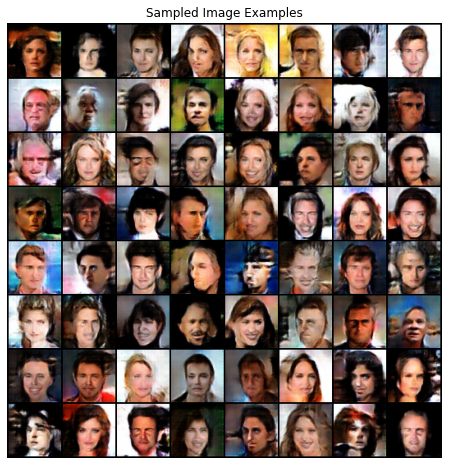

In [15]:
G.eval()
get_sample_image(G, noise_dim=noise_dim)